<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_melting_research_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Snow Melting Prediction With LSTM, TCN and Transformer**

## install required library

In [ ]:
# pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install keras-tcn

## import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# model library
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt


## Load Dataset

In [ ]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


## Dataset Pre-processing

In [ ]:
df_snow_melting = df_snow_melting[['Date',"Q","SCA","T"]]

In [ ]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [ ]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

<ipython-input-125-df5f3d927db8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T
0,2001-01-01,2.69,345.815123,-4.169740
1,2001-01-02,2.53,343.608727,-4.142604
2,2001-01-03,2.53,341.437417,-5.148725
3,2001-01-04,2.43,339.336277,-6.523695
4,2001-01-05,2.53,337.340394,-6.860106
...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230
4013,2012-12-27,2.91,219.264614,-5.501225
4014,2012-12-28,3.03,210.043412,-5.526874
4015,2012-12-29,2.97,201.080703,-5.107484


## Data visualization in time series

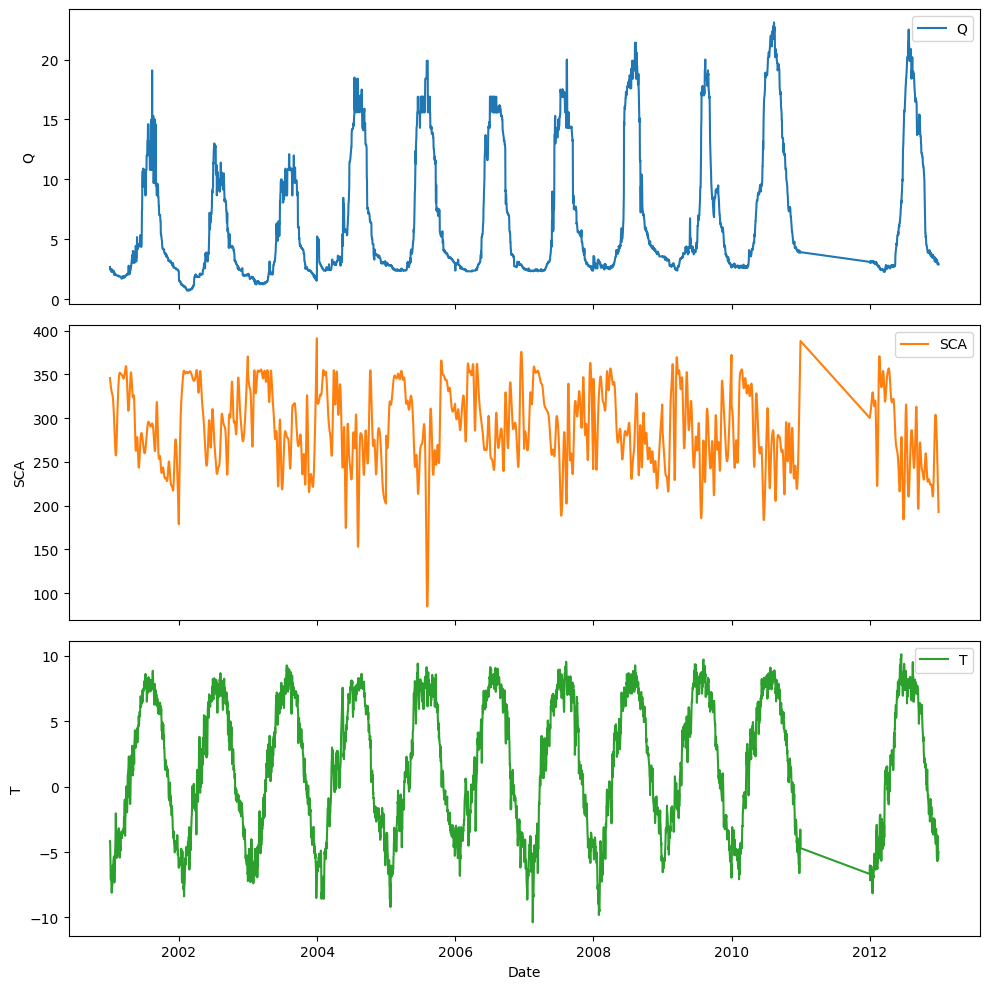

In [ ]:
columns_to_plot = ['Q', 'SCA', 'T']

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Data Normalization

In [ ]:

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Define the columns to be scaled (excluding the 'Date' column)
columns_to_scale = ['SCA', 'T']

# test

df_snow_melting[columns_to_scale] = scaler.fit_transform(df_snow_melting[columns_to_scale])
df_snow_melting



<ipython-input-127-c8bb3bd7978b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting[columns_to_scale] = scaler.fit_transform(df_snow_melting[columns_to_scale])


,Date,Q,SCA,T
0,2001-01-01,2.69,1.306925,-1.170123
1,2001-01-02,2.53,1.255788,-1.164703
2,2001-01-03,2.53,1.205464,-1.365690
3,2001-01-04,2.43,1.156767,-1.640360
4,2001-01-05,2.53,1.110509,-1.707563
...,...,...,...,...
4012,2012-12-26,2.91,-1.409374,-1.466072
4013,2012-12-27,2.91,-1.626085,-1.436107
4014,2012-12-28,3.03,-1.839801,-1.441230
4015,2012-12-29,2.97,-2.047526,-1.357451


In [ ]:
# Define the feature columns (X) and target column (y)
feature_columns = ['SCA', 'T']
target_column = 'Q'

X, y = df_snow_melting[feature_columns], df_snow_melting[target_column]

X,y = X.values,y.values


# Split dataset as train test and val


In [ ]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training

# Further split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing


In [ ]:
#  reshape the data to fit in model for Lstm (3D array)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
print("Train shape",X_train.shape)
print("val shape",X_val.shape)
print("Test shape",X_test.shape)

Train shape (3213, 2, 1)
val shape (402, 2, 1)
Test shape (402, 2, 1)


# LSTM (Long Short Term Memory)

## Create model

In [ ]:

model = Sequential()


model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

optimizer = Adamax(learning_rate=0.01,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_56 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)


Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 35.6210 - mae: 4.2695 - mse: 35.6210 - val_loss: 13.7320 - val_mae: 2.7748 - val_mse: 13.7320
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 11.4882 - mae: 2.4380 - mse: 11.4882 - val_loss: 8.7823 - val_mae: 2.1319 - val_mse: 8.7823
Epoch 3/100
101/101 [==============================] - 0s 4ms/step - loss: 9.5291 - mae: 2.1991 - mse: 9.5291 - val_loss: 8.0172 - val_mae: 1.9913 - val_mse: 8.0172
Epoch 4/100
101/101 [==============================] - 0s 4ms/step - loss: 9.2903 - mae: 2.1597 - mse: 9.2903 - val_loss: 8.1466 - val_mae: 2.0338 - val_mse: 8.1466
Epoch 5/100
101/101 [==============================] - 0s 4ms/step - loss: 9.4756 - mae: 2.1491 - mse: 9.4756 - val_loss: 7.6734 - val_mae: 1.9324 - val_mse: 7.6734
Epoch 6/100
101/101 [==============================] - 0s 4ms/step - loss: 9.0379 - mae: 2.0927 - mse: 9.0379 - val_loss: 7.4971 - val_mae: 1.8957 - val_mse: 7.4971
Epoc

# Hyperparameter Tuning

# Model Testing

## Train Dataset

101/101 [==============================] - 0s 2ms/step
MAE: 1.8163622495008338
RMSE: 2.721058384233963
R-squared (R2): 0.7494367022616666


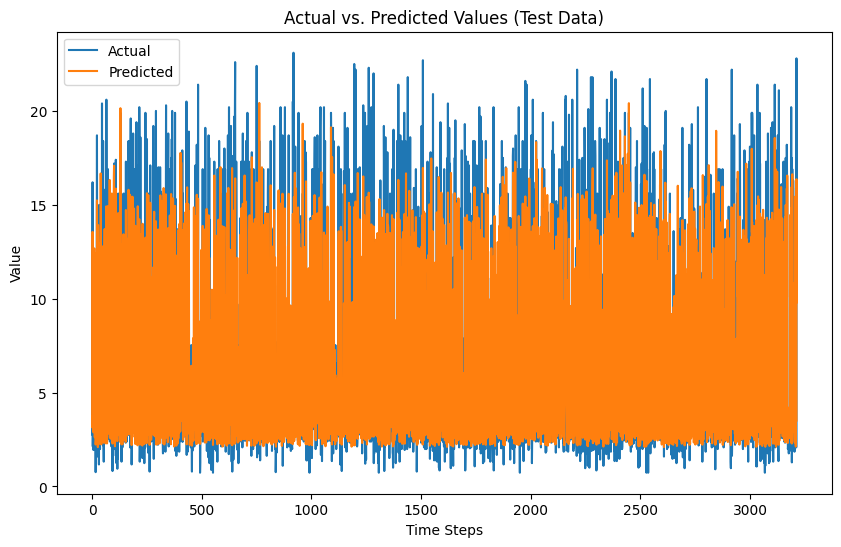

In [ ]:
# Get the model's predictions on the test data
y_train_pred = model.predict(X_train)

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R2
r2 = r2_score(y_train, y_train_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

# Plot the actual vs. predicted values from the test set
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()


## Validation dataset

13/13 [==============================] - 0s 2ms/step
MAE: 1.6743594165204174
RMSE: 2.5743483935757285
R-squared (R2): 0.7673644999629897


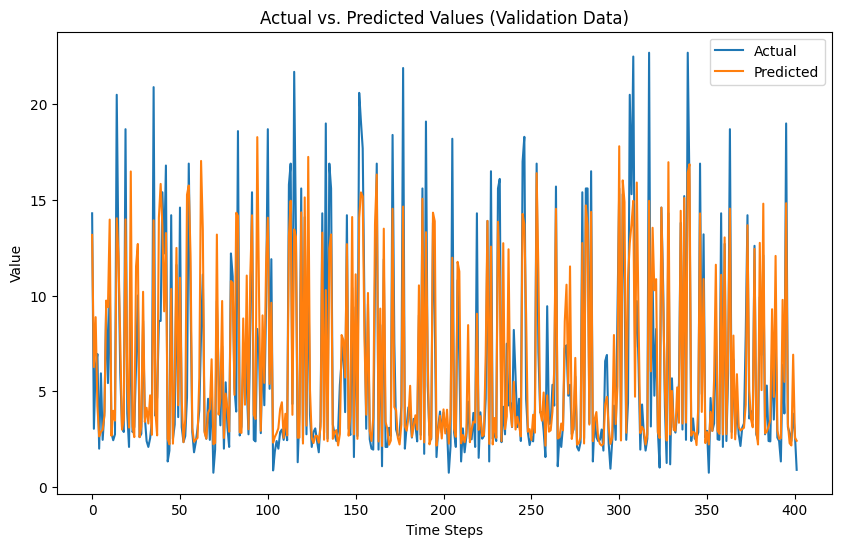

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_val_pred = model.predict(X_val)
# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate R2
r2 = r2_score(y_val, y_val_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)
# Plot the actual vs. predicted values from the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

## Testing Dataset

13/13 [==============================] - 0s 3ms/step
MAE: 1.5962281805389558
RMSE: 2.4185274278864295
R-squared (R2): 0.8034073202373708


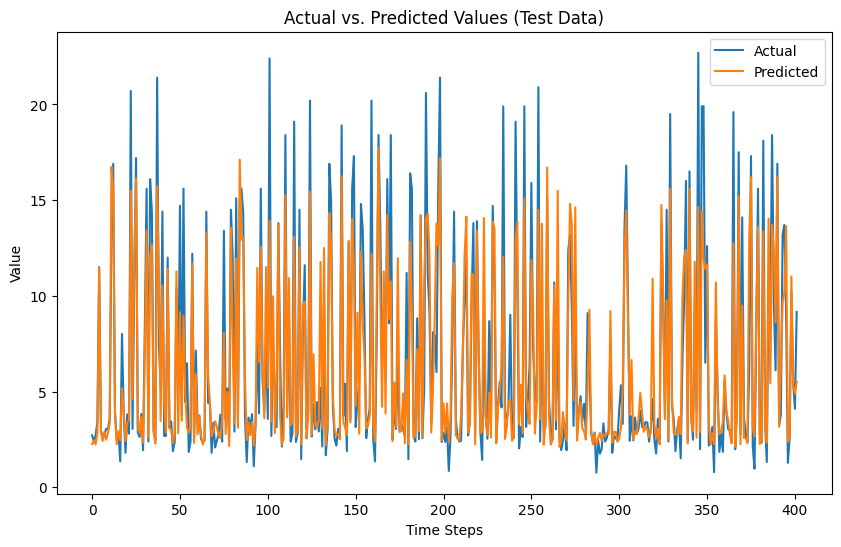

In [ ]:
# Get the model's predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R2
r2 = r2_score(y_test, y_test_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

# Plot the actual vs. predicted values from the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()
